# Your first neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). After you've submitted this project, feel free to explore the data and the model more.



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

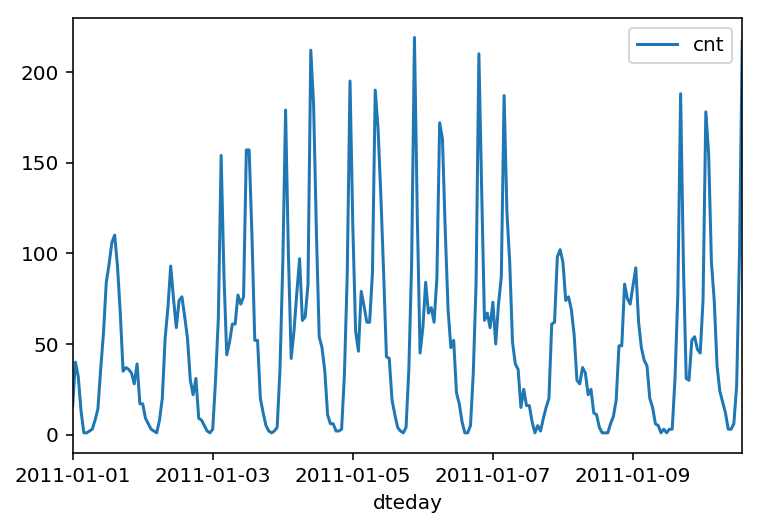

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, we'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Time to build the network

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

<img src="assets/neural_network.png" width=300px>

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [9]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        # -- Set self.activation_function to your implemented sigmoid function ####
        self.activation_function = lambda x : 1.0/(1.0 + np.exp(-x))  # Replace 0 with your sigmoid calculation.
                    
    
    def train(self, features, targets):
        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets):
            
            #### Implement the forward pass here ####
            ### Forward pass ###
            # -- Hidden layer 
            hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
            hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
            # -- Output layer
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
            final_outputs = final_inputs.reshape(y.shape) # signals from final output layer
            
            #### Implement the backward pass here ####
            ### Backward pass ###

            # -- Output error
            # Output layer error is the difference between desired target and actual output.
            # This is the error at the output of the output layer
            error = y - final_outputs

            # -- Output error term
            # The propagated error from the output layer, with activation: f(h) = h
            # This is the error at each of the inputs of the output layer. In this network
            # there is one output neuron in the output layer. So, there is only one input into 
            # this layer.
            # delta_o = error * f'(h) = error * 1
            output_error_term = error * 1.

            # -- Calculate the hidden layer's contribution to the error
            # This is the error at the output of each neuron of the hidden layer
            # Each of these neurons has contributed a weighted amount of error to the 
            # to the output layer's error. 
            # Note: since there is one neuron that the hidden layer is connected to,
            #       the following multiplication is equivalent to a vector multiplied
            #       with a constant. I'm leaving the 'dot' notation to point out
            #       the general case where there are multiple neurons in the output 
            #       layer, and each hidden neuron's error at their output, is the weighted
            #       sum of the errors of the output layer's neurons error at their input.
            hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
            
            # -- Backpropagated error terms 
            # This is the error at each of the hidden layer's neurons inputs
            # The hidden layer activation is a sigmoid. Sigmoid's derivative is:
            # output * (1 - output). So here, we're finding the error gradient at the input
            # of the sigmoid function
            hidden_error_term = hidden_error * (hidden_outputs * (1. - hidden_outputs))
            
            # Comments: To generate each neuron's input, we perform a summation: Sum(W, X). Note that 
            #           this is a function with two inputs: weights (W) and X. These sum() functions generate
            #           the inputs into each of the neurons of the layer.
            #           It helps to think of the summation as the "arrows going into" the layer
            #           than part of the layer op (node). So the layer ops (the nodes in the graph)
            #           are the activation functions. 
            #           But these are arithmetic nodes nonetheless: Sum(W, X). Their "local" derivative w.r.t 
            #           their inputs is d(Sum(W, X))/dX = W, and d(Sum(W, X))/dW = X
            #           To find the error gradient at each of these sum()-function inputs, we back-propagate
            #           the error at their outputs, which IS the error term of the layer's input, and their 
            #           local gradient w.r.t to their input.
            #           so: dError/dW = dErrorOutput * d(Sum(W, X))/dW = dErrorOutput * X, where dErrorOutput is the error term
            #           at the layer's input
            #           ... so pretty much we're still doing the same thing as we did above here           
            #
            # Weight step (input to hidden)
            delta_weights_i_h += hidden_error_term * X[:,None]
            # Weight step (hidden to output)
            delta_weights_h_o += output_error_term * hidden_outputs[:,None]

        # -- Update the weights
        # update hidden-to-output weights with gradient descent step
        self.weights_hidden_to_output += (self.lr / n_records)*delta_weights_h_o
        # update input-to-hidden weights with gradient descent step
        self.weights_input_to_hidden += (self.lr / n_records)*delta_weights_i_h 
 
    def run(self, features):
        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Forward pass ####
        # Hidden layer 
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        # Output layer
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.005s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but **not** overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops. 

* To avoid overfitting, the best validation-scoring model is saved
* Implemented a flag to early terminate the training


#### Training Algorithm
Stochastic Gradient Descent (SGD) is used to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.


*Training is encapsulated in the method below*


In [15]:
import sys
def train_model(iterations, learning_rate, hidden_nodes, output_nodes, early_term = False, iter_patience = 100):
    
    '''
    Train a neural network.
    
    :param iterations - training iterations
    :param learning_rate - learning rate
    :hidden_nodes - number of hidden nodes
    :output_nodes - number of output nodes
    :early_term - early termination flag. Default false
    :iter_patience - in early termination, max number of iterations to be patient for
    '''
    
    N_i = train_features.shape[1]
    network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

    losses = {'train':[], 'validation':[]}
    
    best_valid_loss = np.inf
    iterations_from_best_valid = 0
    best_valid_network = None
    
    for ii in range(iterations):
        # Go through a random batch of 128 records from the training data set
        batch = np.random.choice(train_features.index, size=128)
        X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt'].values[:,None]
        network.train(features=X, targets=y)

        # Printing out the training progress
        train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
        sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                         + "% ... Training loss: " + str(train_loss)[:5] \
                         + " ... Validation loss: " + str(val_loss)[:5])
        sys.stdout.flush()
        
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
        
        # Is this the best validation network ?
        if val_loss < best_valid_loss:
            iterations_from_best_valid = 0
            best_valid_network = network
        else:
            iterations_from_best_valid +=1
        
        if early_term:
            if iterations_from_best_valid > iter_patience:
                return network, best_valid_network, losses

        
    return network, best_valid_network, losses

### Vizualize the results

The following method below, plots the results over specific hyper-paramters.


In [13]:
def res_viz(key_param, results):
    
    SMALL_SIZE = 8
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14
    MASSIVE_SIZE = 40

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=MASSIVE_SIZE)  # fontsize of the figure title

    
    plt.figure(figsize=(10,15))
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    ylim_min, ylim_max = 0.0, 2.
    for k, vals in results.items():
        lbl1 = '{0}: {1}'.format(key_param, k)
        ax1.plot(vals[1]['train'], label=lbl1)
        ax1.set_ylim([ ylim_min, ylim_max])
        ax1.set_title('Train Loss', fontsize=20)
        ax1.legend()
        ax1.grid(True)
        
        lbl2 = '{0} : {1}'.format(key_param, k)
        ax2.plot(vals[1]['validation'], label=lbl2)
        ax2.set_title('Validation Loss', fontsize=20)
        ax2.set_ylim([ ylim_min, ylim_max])
        ax2.legend()
        ax2.grid(True)
    plt.tight_layout()

---

## Evaluate number of iterations
The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum. As you start overfitting, you'll see the training loss continue to decrease while the validation loss starts to increase.

* In the graph below, while a bit hard to see, you can see that the error graph has negative slope (going down) while validation error graph is starting to get a positive slope (in the mean) and increased variance (in the sample). So the more we train, we should expect a decrease in training loss and an increase in the validation loss.

Progress: 100.0% ... Training loss: 0.063 ... Validation loss: 0.161

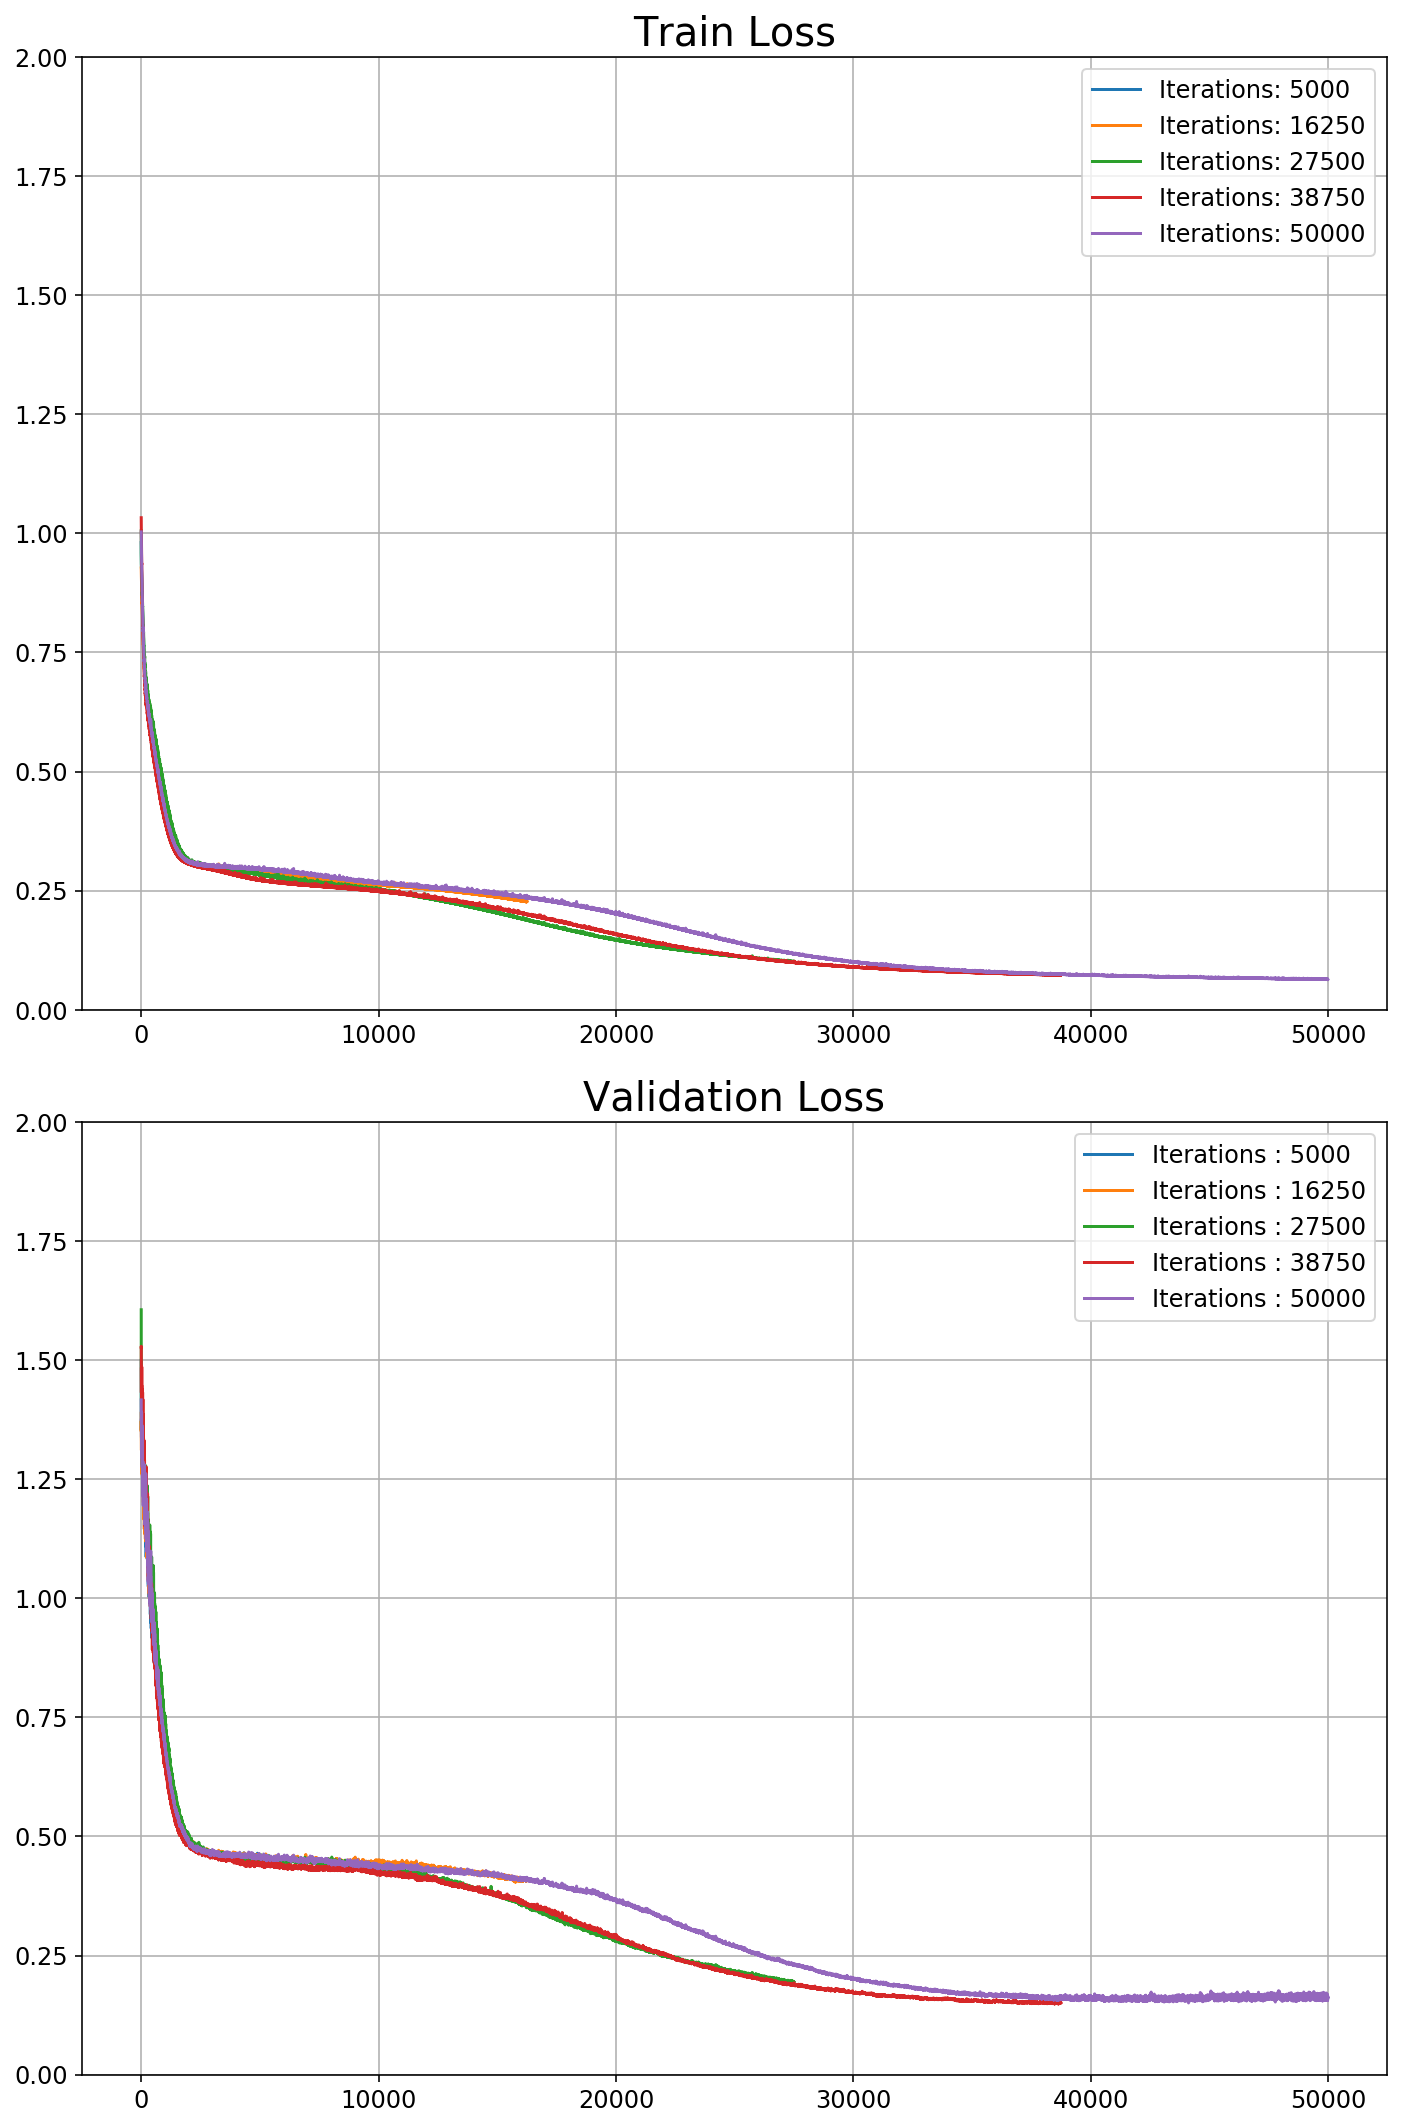

In [16]:
### Set the hyperparameters here ###
iterations = np.linspace(5000, 50000, 5, dtype = np.int)
learning_rate = 0.05
hidden_nodes = 30
output_nodes = 1

results = {}

for it_ in iterations:
    net, best_valid_net, losses = train_model(iterations=it_, learning_rate=learning_rate, 
                                              hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    results[it_] = (net, losses)
res_viz('Iterations', results)

---

## Evaluate learning rate
Learning rate scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data (A good choice to start at is 0.1). If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

* Here I'm evaluating several learing rates to show comparative effects between them.
* In the plot we can see that the smallest LR of 0.01 is converging very slow. As we increase the LR we see both training and validation losses decrease faster until LR gets to about 0.4.
* LR greater than 0.4 display a more complex behavior. i) For these higher LRs the gradient has a hard time settling to the narrow minimum of the error surface. The weights end up having erratic (high variance) increases, causing high variance gradients as they are updated. This is shown by the plateau of the loss. ii) However, eventually the network breaks the plateau and reduces its training/validation loss drastically. The high learning rate, by causing such a high variance in the weights, forces the network out of the **local optimums** and cause it to bounce around a broader weight/error space. This eventually results in the finding of a perhaps global optimum in a sort of a blind play of basketball... which is great, BUT .. !! What if we come out of this optimum space due to the high learning rate still in effect ? It would make sense that a reduction of LR may be needed once this condition is detected.

Progress: 100.0% ... Training loss: 0.353 ... Validation loss: 0.489

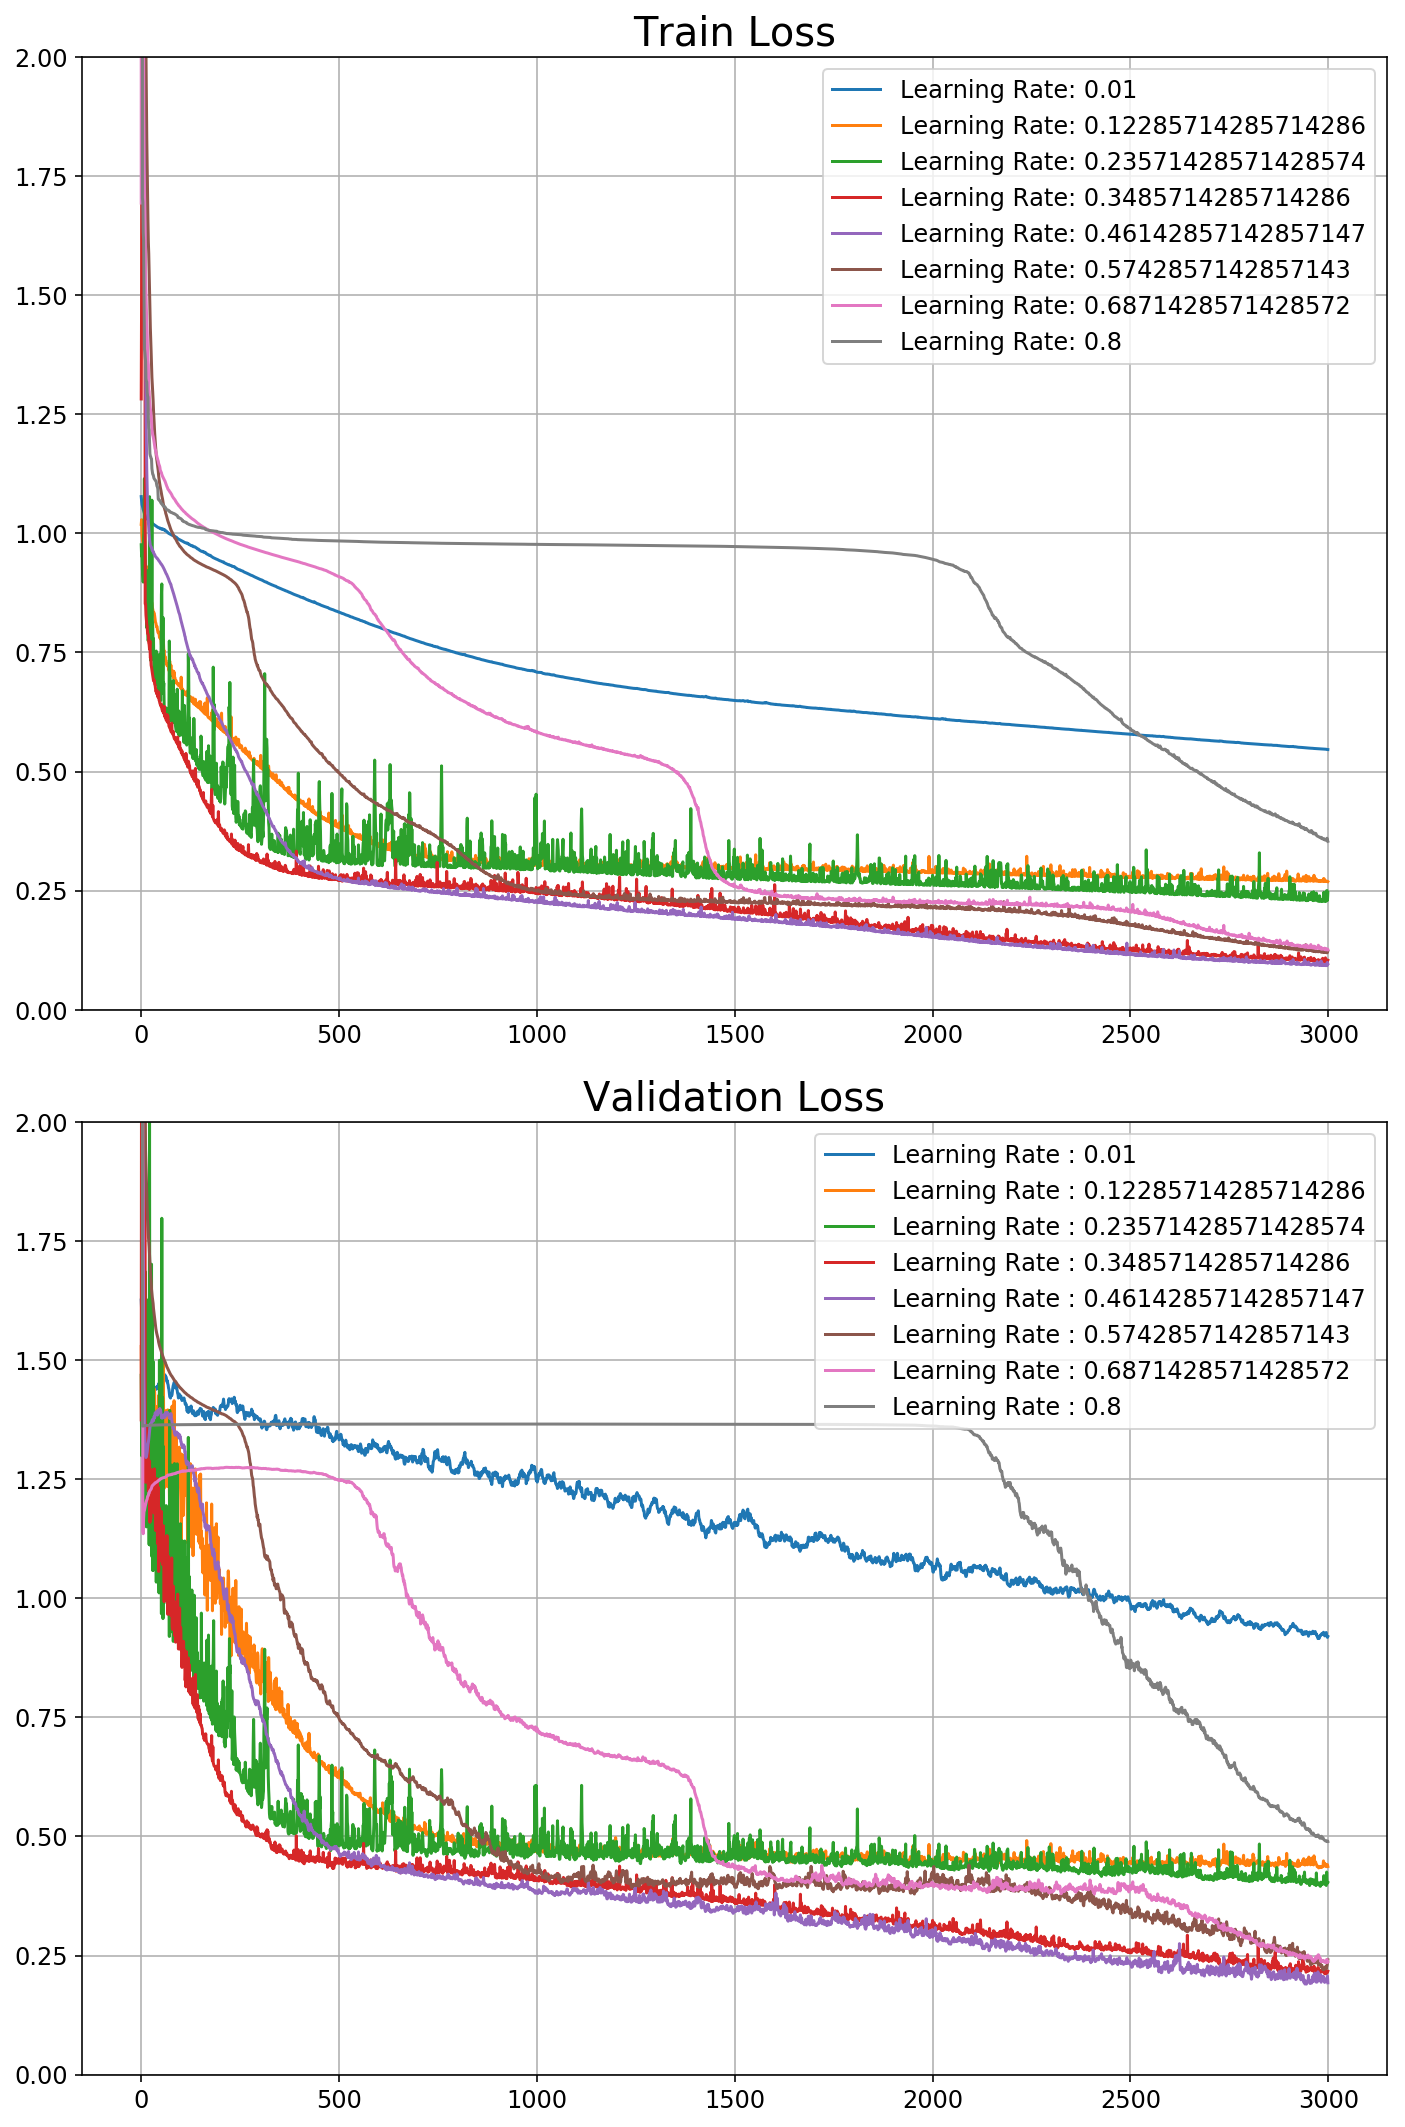

In [123]:
### Set the hyperparameters here ###
iterations = 3000
learning_rate = np.linspace(0.01, 0.8, 8)
hidden_nodes = 30
output_nodes = 1

results = {}

for lr in learning_rate:
    net, best_valid_net, losses = train_model(iterations=iterations, learning_rate=lr, 
                                              hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    results[lr] = (net, losses)
res_viz('Learning Rate', results)

---

## Evaluate  number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

* In the graphs we can see that nodes from 5 -- 20 yields a fairly low error rate. While as we increase the nodes past a certain point, an increase in error (training and validation) is noticed. This reflects an erratic learning behavior past the "appropriate" hidden representations.


Progress: 100.0% ... Training loss: 0.146 ... Validation loss: 0.289

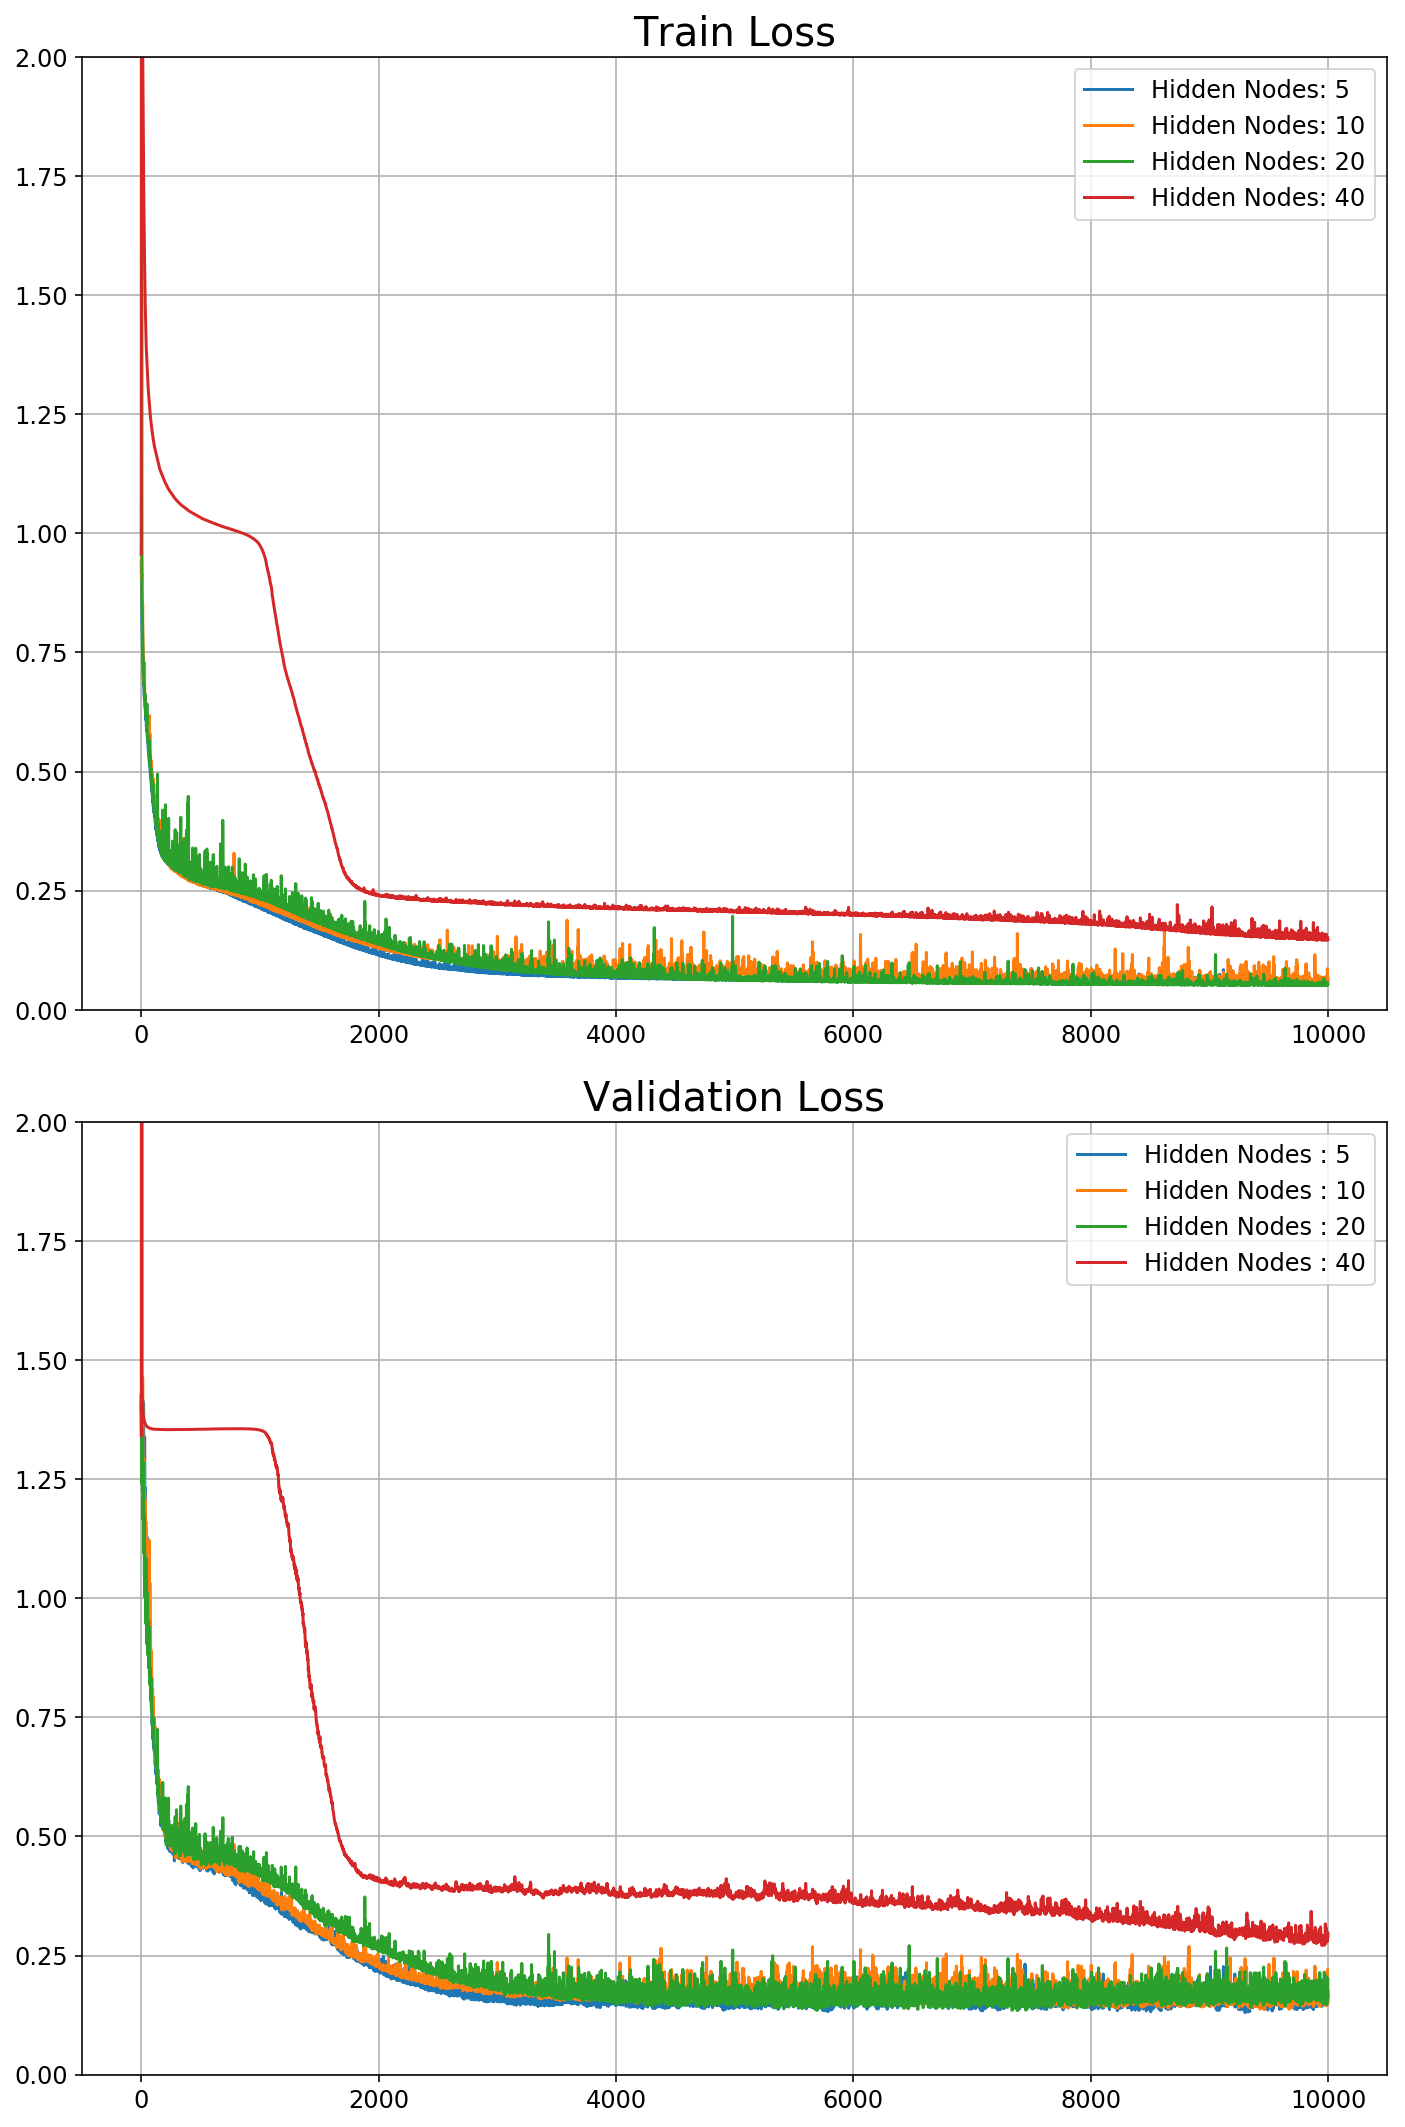

In [125]:
### Set the hyperparameters here ###
iterations = 10000
learning_rate = 0.5
hidden_nodes = [2, 5, 10, 20, 40]
output_nodes = 1

results = {}

for h_nodes in hidden_nodes:
    net, best_valid_net, losses = train_model(iterations=iterations, 
                            learning_rate=learning_rate, 
                            hidden_nodes=h_nodes, 
                            output_nodes=output_nodes)
    results[h_nodes] = (net, losses)
res_viz('Hidden Nodes', results)

## Train final network

In [126]:
iterations = 50000
learning_rate = 0.5
hidden_nodes = 10
output_nodes = 1

results = {}
net, best_valid_net, losses = train_model(iterations=iterations, 
                            learning_rate=learning_rate, 
                            hidden_nodes=hidden_nodes, 
                            output_nodes=output_nodes)
    
# results['Final Net'] = (net, losses)
# res_viz('Final Network', results)

Progress: 100.0% ... Training loss: 0.052 ... Validation loss: 0.180

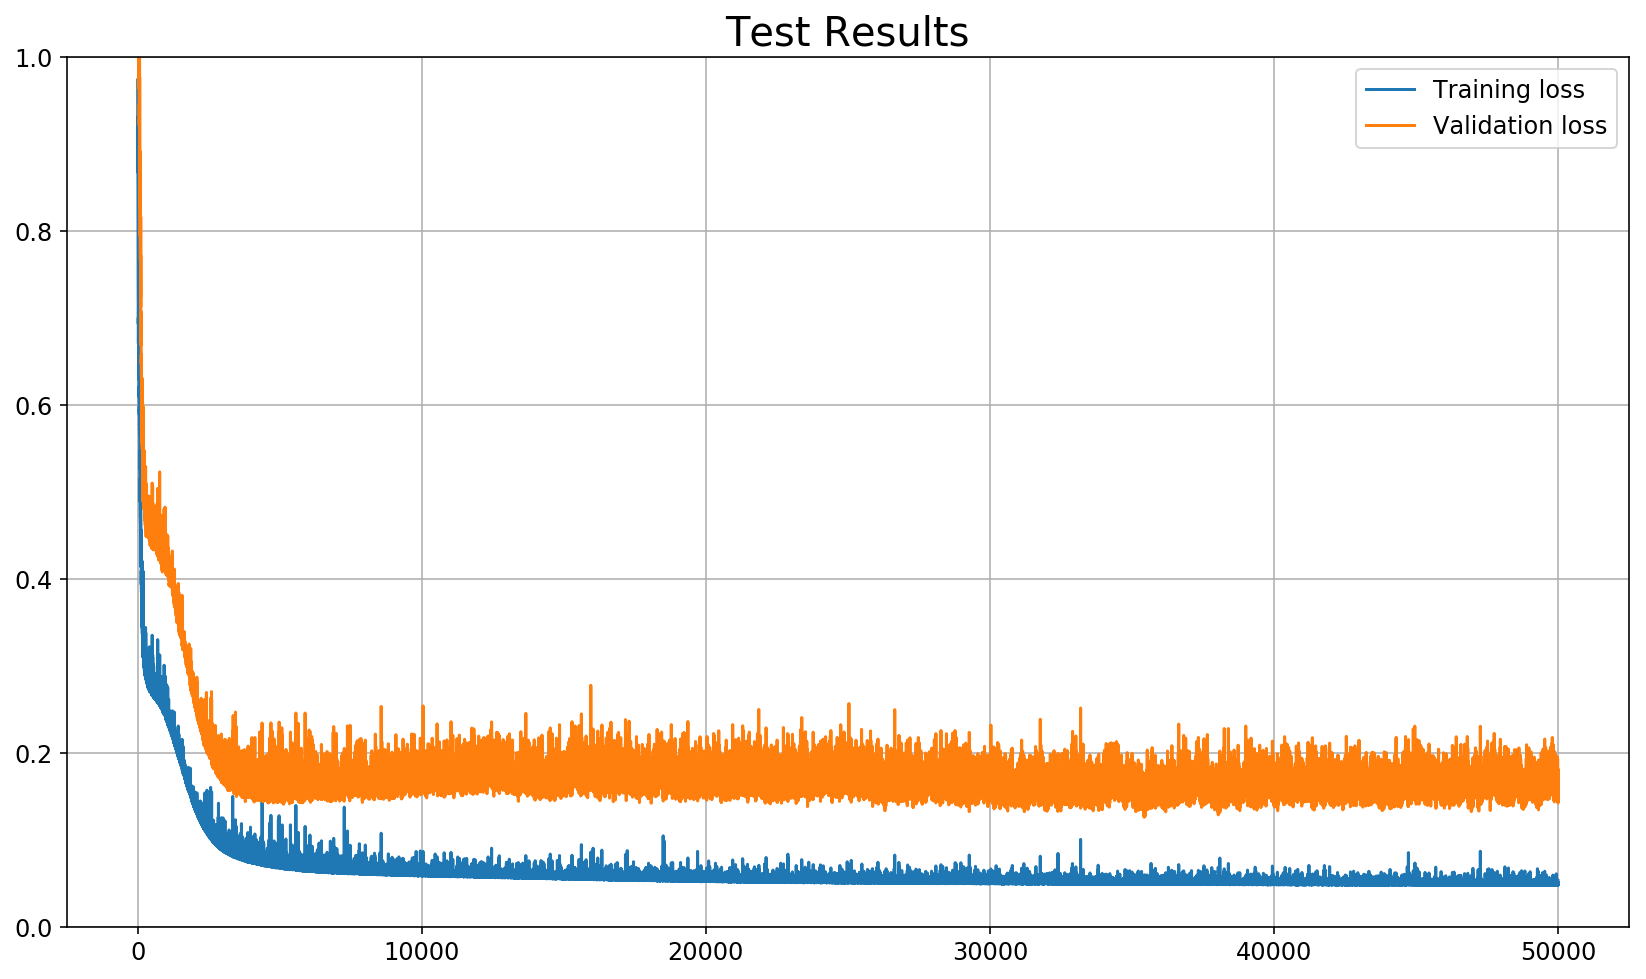

In [144]:
plt.figure(figsize=(14,8))

plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')

plt.legend()
plt.grid()
plt.title('Test Results', fontsize=20)
_ = plt.ylim([0.,1.])

## Check out your predictions

Here, test data to view how well the network is modeling the data.

#### Note : The best validation network being used

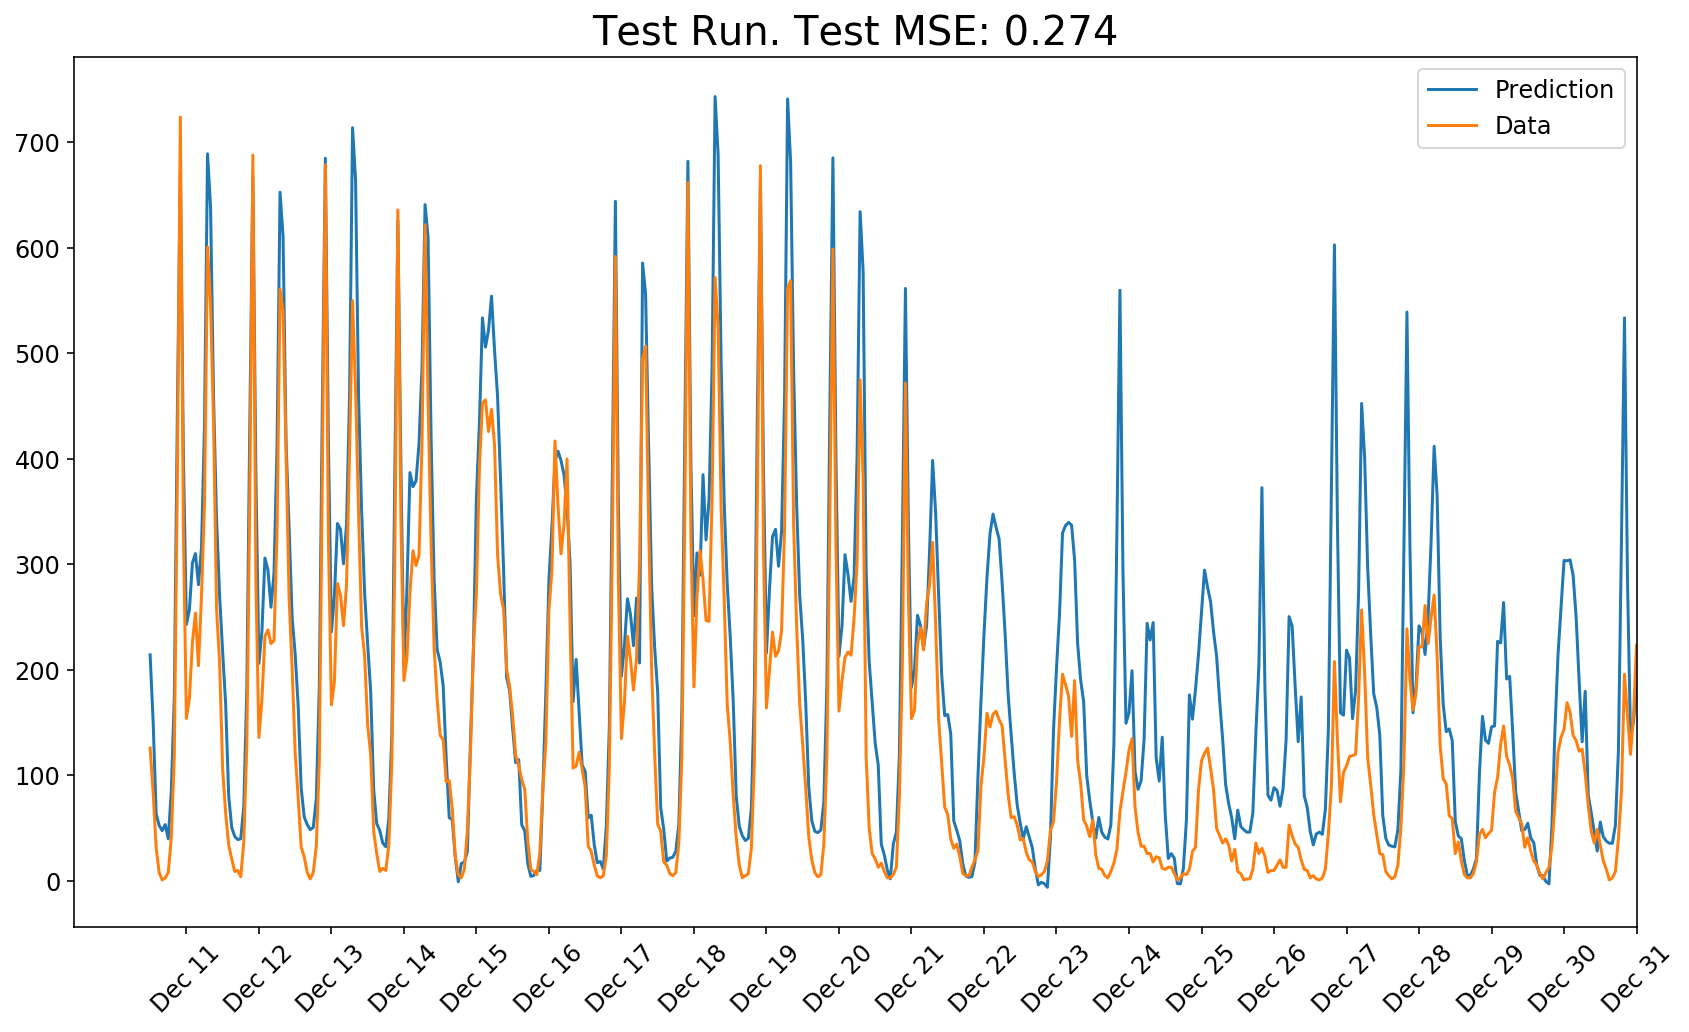

In [145]:
fig, ax = plt.subplots(figsize=(14,8))

mean, std = scaled_features['cnt']
predictions = best_valid_net.run(test_features).T*std + mean

# Obtain MSE 
test_loss = MSE(best_valid_net.run(test_features).T, (test_targets['cnt']).values)

ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()
ax.set_title('Test Run. Test MSE: {0:.3f}'.format(test_loss), fontsize=20)

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)


## OPTIONAL: Thinking about your results(this question will not be evaluated in the rubric).


* *Q: How well does the model predict the data?* 
    Model predicts the results fairly well during most part of December. 


* *Q: Where does it fail?* 
    Model over-predicts during X-mass period, **resembling non-Xmass behavior**. Episodically we know that X-mass is a significant event (i.e. major latent factor) which effects bike rentals. People spend time with each other are busier sitting on couches.


* *Q: Why does it fail where it does?* 
    Systemically thinking, this prediction error could come from three sources: i) system/network doesn't have the signals that encode X-mass events, or ii) the *training* data did not include data from the X-mass season, or finally iii) the network's capacity was insufficient to account for this *latent state*. Starting from the latest, given the particular architecture, adding more hidden nodes should have increased network capacity. However, I selected the hidden nodes with the most sensible validation loss. Higher capacity networks seem to generate higher levels of error (which is an indication of overfitting). Signal which captured holiday-ness of X-mass was there (holiday), so we have the necessary signals. So what remains is that the training data-set did not include any data from X-mass event. 


*Lesson:* training data should be representative of all the variations of the data-generating factors. Practically this means that data generated from these factors should be included in the training set, i.e. in this case, X-mass data should be included in the training set.